In [ ]:
from sklearn.neighbors import NearestNeighbors
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import zscore

In [ ]:
os.chdir('work/ST_Histo/Xenium_BC_10x/')
xen = sc.read_h5ad("xenium_with_leiden.h5ad")
thor_ad = sc.read_h5ad("fineST_BC_10x_50/fineST_geom1.0_snn0.1_trans1.0_reg_20.h5ad")

In [3]:
annotation_xen = {
    '0':'Invasive Tumor',
    '1':'Immune',
    '2':'Stromal',
    '3':'Immune', 
    '4':'Stromal',
    '5':'DCIS #1',
    '6':'DCIS #2',
    '7':'DCIS #2',
    '8':'Myoepithelial',
    '9':'Immune',
    '10':'DCIS #2',
    '11':'Immune',
    '12':'Immune'
}

xen.obs['clusters'] = xen.obs.leiden.map(annotation_xen).copy()
xen.obs['clusters'].head()

1            Immune
2            Immune
3            Immune
4    Invasive Tumor
5            Immune
Name: clusters, dtype: object

### Find nearest cells in Thor for all Xenium clusters

In [4]:
def find_nearest(xen, thor_ad, cutoff_pixels):
    xen_coors = xen.obsm['spatial']
    thor_coors = thor_ad.obsm['spatial']
    nbrs = NearestNeighbors(n_neighbors=1).fit(thor_coors)
    distances, indices = nbrs.kneighbors(xen_coors)
    xen_closest = thor_ad[indices.ravel()].copy()
    xen_closest.obs['distances'] = distances.ravel()
    xen_closest.obs.index = xen.obs.index
    xen_closest.obs['close'] = xen_closest.obs['distances'] <= cutoff_pixels
    xen_closest.obs['clusters'] = xen.obs['clusters']
    closest_cluster_mean = grouped_obs_mean(xen_closest[xen_closest.obs.close], 'clusters')
    xen_cluster_mean = grouped_obs_mean(xen[xen_closest.obs.close, thor_ad.var_names], 'clusters')

    return closest_cluster_mean, xen_cluster_mean

def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [5]:
closest_cluster_mean, xen_cluster_mean = find_nearest(xen, thor_ad, 40)

/condo/wanglab/tmhpxz9/conda_env/thor.0.1.1/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/condo/wanglab/tmhpxz9/conda_env/thor.0.1.1/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/condo/wanglab/tmhpxz9/conda_env/thor.0.1.1/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/condo/wanglab/tmhpxz9/conda_env/thor.0.1.1/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

[]

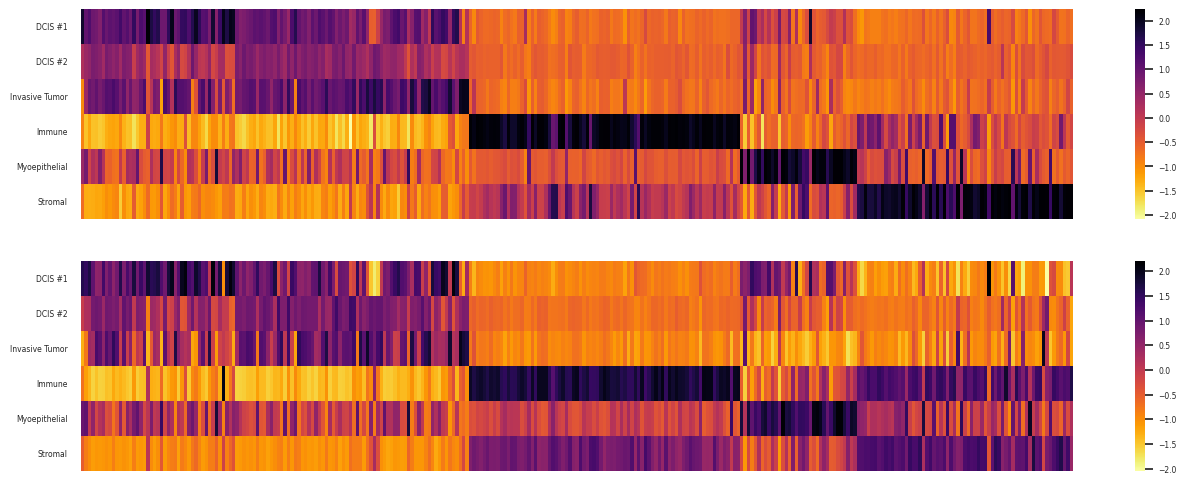

In [6]:
sns.set(font_scale=0.5)

sc.tl.rank_genes_groups(xen, groupby='clusters')

clusters_order = ['DCIS #1', 'DCIS #2', 'Invasive Tumor', 'Immune', 'Myoepithelial', 'Stromal']
lg_list = []
for lk in clusters_order:
    genes = list(sc.get.rank_genes_groups_df(xen, group=lk, pval_cutoff=0.01, log2fc_min=2).names.values)
    lg_list += genes

fig, axes = plt.subplots(figsize=(16, 6), nrows=2)
sns.heatmap(xen_cluster_mean.loc[lg_list, clusters_order].T.apply(zscore), cmap="inferno_r", ax=axes[0], xticklabels = 3)
sns.heatmap(closest_cluster_mean.loc[lg_list, clusters_order].T.apply(zscore), cmap="inferno_r", ax=axes[1], xticklabels = 3)

# Hide grid lines
axes[0].grid(False)
axes[1].grid(False)

# Hide axes ticks
axes[0].set_xticks([])
axes[1].set_xticks([])


In [9]:
xen_cluster_mean.to_csv("xenium_cluster_mean.csv")
closest_cluster_mean.to_csv("thor_closest_cluster_mean.csv")